https://jovian.ai/aakashns/sklearn-decision-trees-random-forests

# **Todo**

> **EXERCISE**: Explore and experiment with other arguments of `DecisionTree`. Refer to the docs for details: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

> **EXERCISE**: A more advanced technique (but less commonly used technique) for reducing overfitting in decision trees is known as cost-complexity pruning. Learn more about it here: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html . Implement cost complexity pruning. Do you see any improvement in the validation accuracy?

> **EXERCISE**: Find the best hyperparameters and combine them toghether.

# **Informations**

## The following topics are covered


- Downloading a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization

## Problem Statement

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations.

>You are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

## **Processing Correct Order**

* Split the data
→ train_test_split(X, y)
Reason: Prevents test data from leaking into preprocessing steps.

* Impute missing values
→ e.g., SimpleImputer on both numeric and categorical columns.
Important: Fit only on training data, apply to both sets.

* One-hot encoding
→ e.g., OneHotEncoder(handle_unknown='ignore')
Important: Fit on training data only, transform both.

* Oversampling
→ e.g., SMOTE, RandomOverSampler (on training data only)
SMOTE works only with numeric data, so you must encode categorical features first.

* Normalization / Standardization
→ e.g., StandardScaler
Only on numerical columns, fit on training data.

# **Imports**

In [45]:
import kagglehub

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

In [47]:
from sklearn.tree import plot_tree, export_text

In [48]:
pd.set_option('future.no_silent_downcasting', True)

plt.style.use("Solarize_Light2")

# **ENV**

In [49]:
# scalar = MinMaxScaler
scalar = StandardScaler

imputer = SimpleImputer(strategy="mean")
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# **Load Dataset**

In [50]:
# Download latest version
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-dataset-rattle-package


In [51]:
rain_df = pd.read_csv(f"{path}/weatherAUS.csv")

# **Explore the Dataset**

In [52]:
rain_df.shape

(145460, 23)

In [53]:
rain_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

## info & describe

In [54]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [55]:
rain_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## Get Numerical and Categorical Columns

In [56]:
numericalCols = rain_df.select_dtypes(include=[np.number]).columns
categoricalCols = rain_df.select_dtypes(exclude=[np.number]).columns

In [57]:
print(numericalCols)
print(categoricalCols)

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'RainToday', 'RainTomorrow'],
      dtype='object')


## Explore Numericals

In [58]:
rain_df[numericalCols].nunique()

,0
MinTemp,389
MaxTemp,505
Rainfall,681
Evaporation,358
Sunshine,145
WindGustSpeed,67
WindSpeed9am,43
WindSpeed3pm,44
Humidity9am,101
Humidity3pm,101


In [59]:
rain_df[numericalCols].isna().sum().sort_values(ascending=False)

,0
Sunshine,69835
Evaporation,62790
Cloud3pm,59358
Cloud9am,55888
Pressure9am,15065
Pressure3pm,15028
WindGustSpeed,10263
Humidity3pm,4507
Temp3pm,3609
Rainfall,3261


>There are a lot missing values, It's better to fill them rather than drop them!

## Explore Categoricals

In [60]:
rain_df[categoricalCols].nunique()

,0
Date,3436
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16
RainToday,2
RainTomorrow,2


>Date is not categorical

>RainToday and RainTomorrow are binary categorical

In [61]:
rain_df[categoricalCols].isna().sum().sort_values(ascending=False)

,0
WindDir9am,10566
WindGustDir,10326
WindDir3pm,4228
RainTomorrow,3267
RainToday,3261
Location,0
Date,0


>we will drop the rows that have a missing values because the number of rows with missing values is relatively small

# **Preparing the Data for Training**

0. Drop Categorical NaNs
1. Identify input and target columns
2. Identify numeric and categorical columns
3. Create a train/test/validation split
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors
7. Oversampling Train dataset

# Common Mistakes to Avoid:

    Normalizing before splitting → causes data leakage.

    Oversampling before splitting → synthetic samples could end up in both train and test sets, inflating performance.

    Imputing before splitting → test set statistics influence training.

    Fitting the encoder or imputer on the full dataset → data leakage.

    Applying SMOTE before encoding → SMOTE requires numeric inputs only.

# **Data Processing**

## Drop Categorical NaNs

In [62]:
print(rain_df.shape)
rain_df.dropna(subset=categoricalCols, inplace=True)
print(rain_df.shape)

(145460, 23)
(123710, 23)


## Convert RainToday, RainTomorrow to Number

In [63]:
rain_df["RainToday"] = rain_df["RainToday"].replace({"Yes": 1, "No": 0}).astype(np.int8)
rain_df["RainTomorrow"] = rain_df["RainTomorrow"].replace({"Yes": 1, "No": 0}).astype(np.int8)
rain_df.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
33677,2009-06-07,SydneyAirport,10.0,19.9,0.8,3.8,6.6,NW,48.0,NNW,...,84.0,37.0,1008.0,1004.6,7.0,2.0,12.3,19.2,0,0
124511,2010-11-20,SalmonGums,14.0,35.0,0.0,NaN,NaN,E,44.0,NE,...,33.0,11.0,NaN,NaN,NaN,NaN,25.7,33.9,0,0
77924,2017-04-22,Portland,15.1,17.9,1.2,NaN,NaN,SSE,20.0,SW,...,94.0,87.0,1023.9,1023.5,7.0,8.0,15.6,16.4,1,0
53897,2014-03-09,MountGinini,8.1,16.1,0.8,NaN,NaN,NE,39.0,ENE,...,98.0,81.0,NaN,NaN,NaN,NaN,8.4,14.1,0,1
70477,2009-03-26,Mildura,17.1,28.4,0.0,8.8,11.2,SSE,39.0,S,...,70.0,36.0,1021.1,1020.8,3.0,1.0,18.9,26.9,0,0


## Get Scalar, Numerical, Categorical and Target cols

In [64]:
scalar_cols = numericalCols.tolist().copy()
numerical_cols = np.append(numericalCols, 'RainToday').tolist()
categorical_cols = categoricalCols[1:-2].tolist()
target_col = ['RainTomorrow']

In [65]:
print(scalar_cols)
print(numerical_cols)
print(categorical_cols)
print(target_col)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['RainTomorrow']


# **Data Visualization**

## Histogram

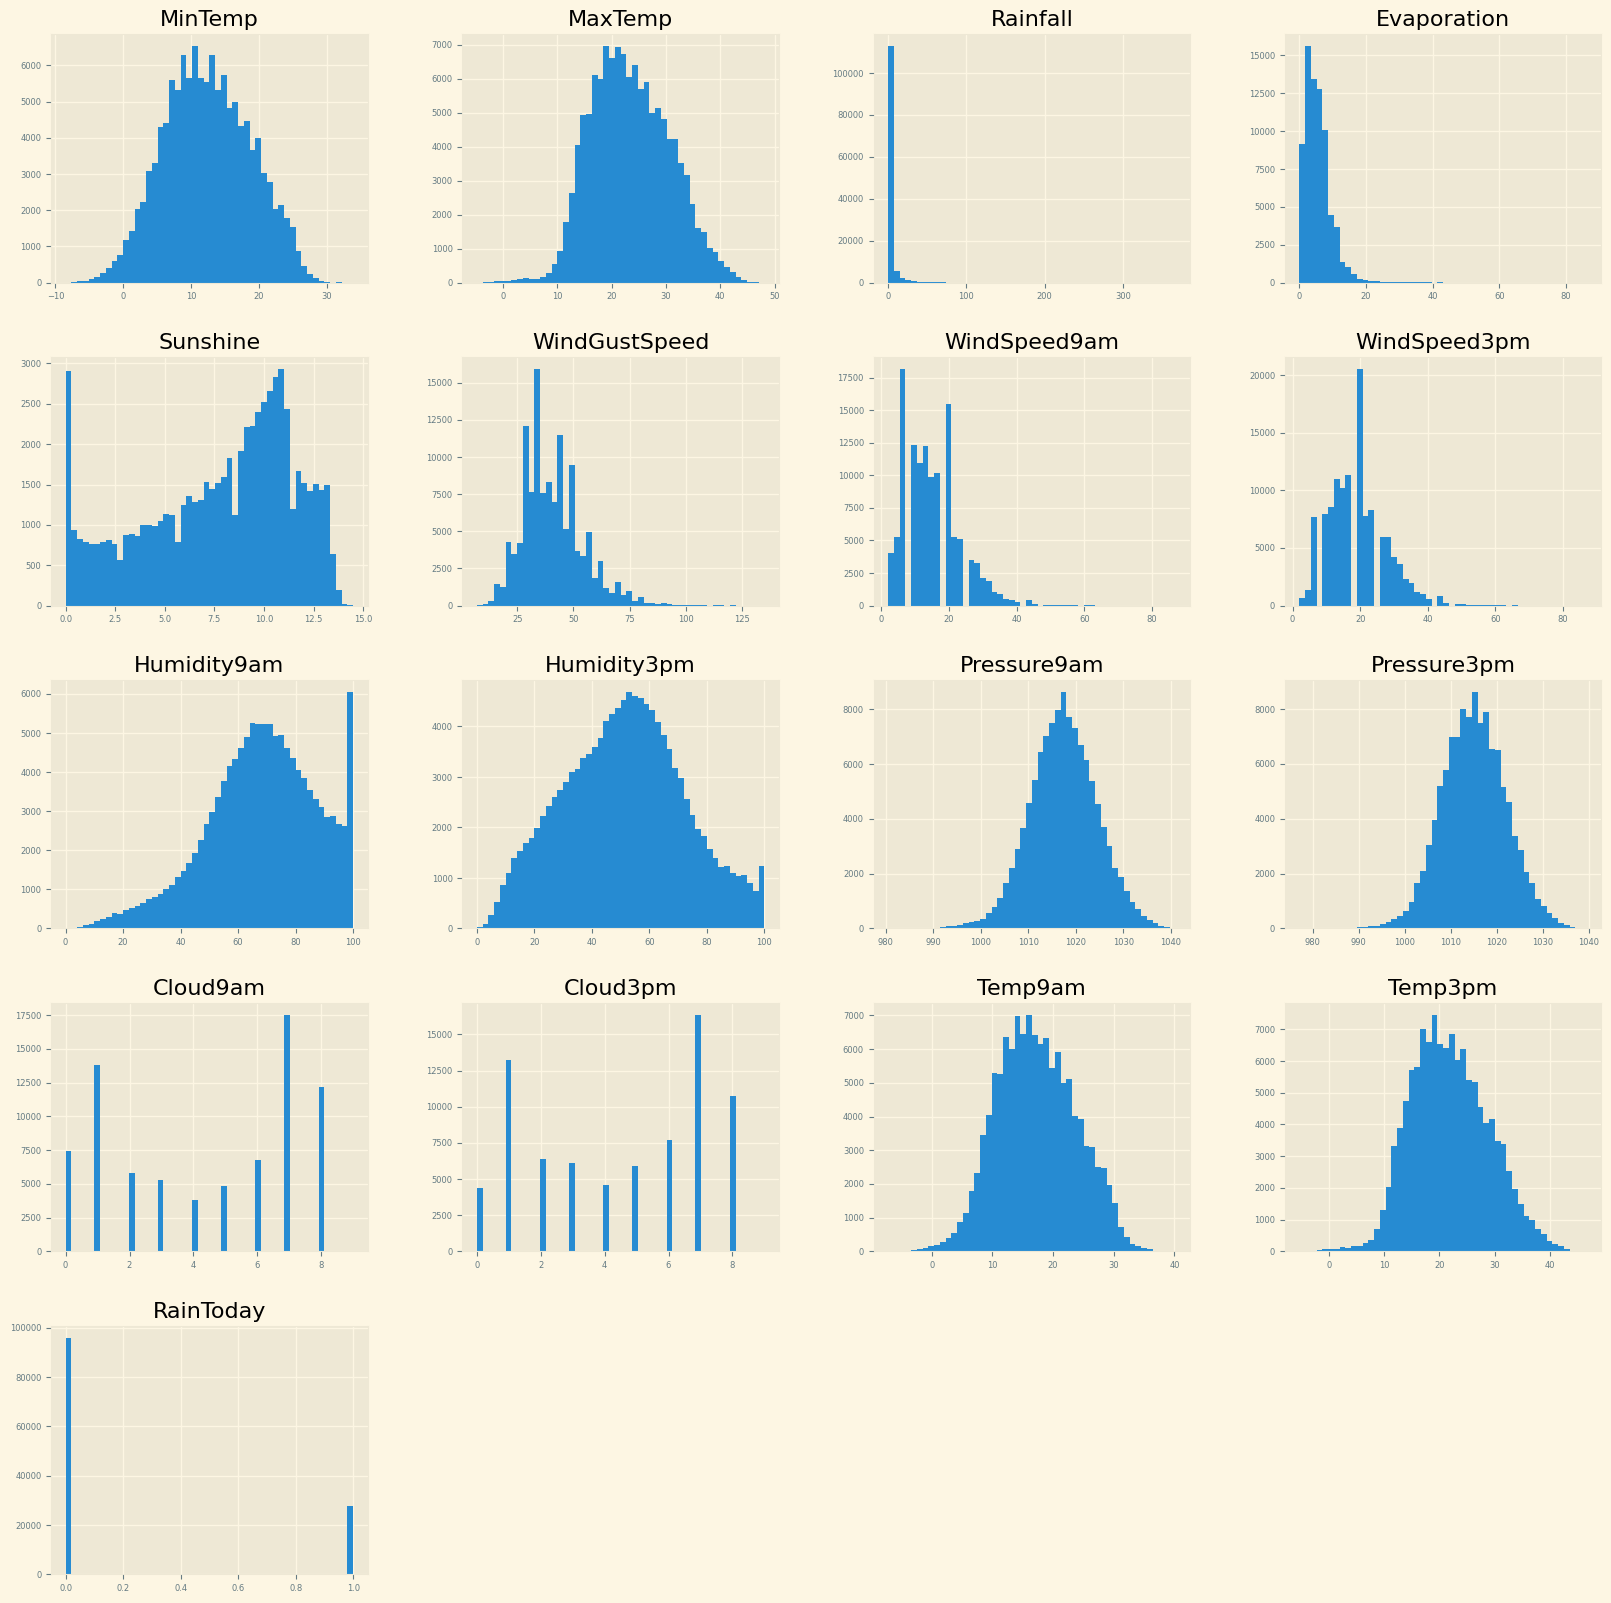

In [66]:
rain_df[numerical_cols].hist(figsize=(20, 20), bins=50, xlabelsize=6, ylabelsize=6);

## Kernel Density Estimate (KDE)
A smooth version of a histogram—instead of showing counts in bins, it estimates the underlying distribution using a smooth curve.

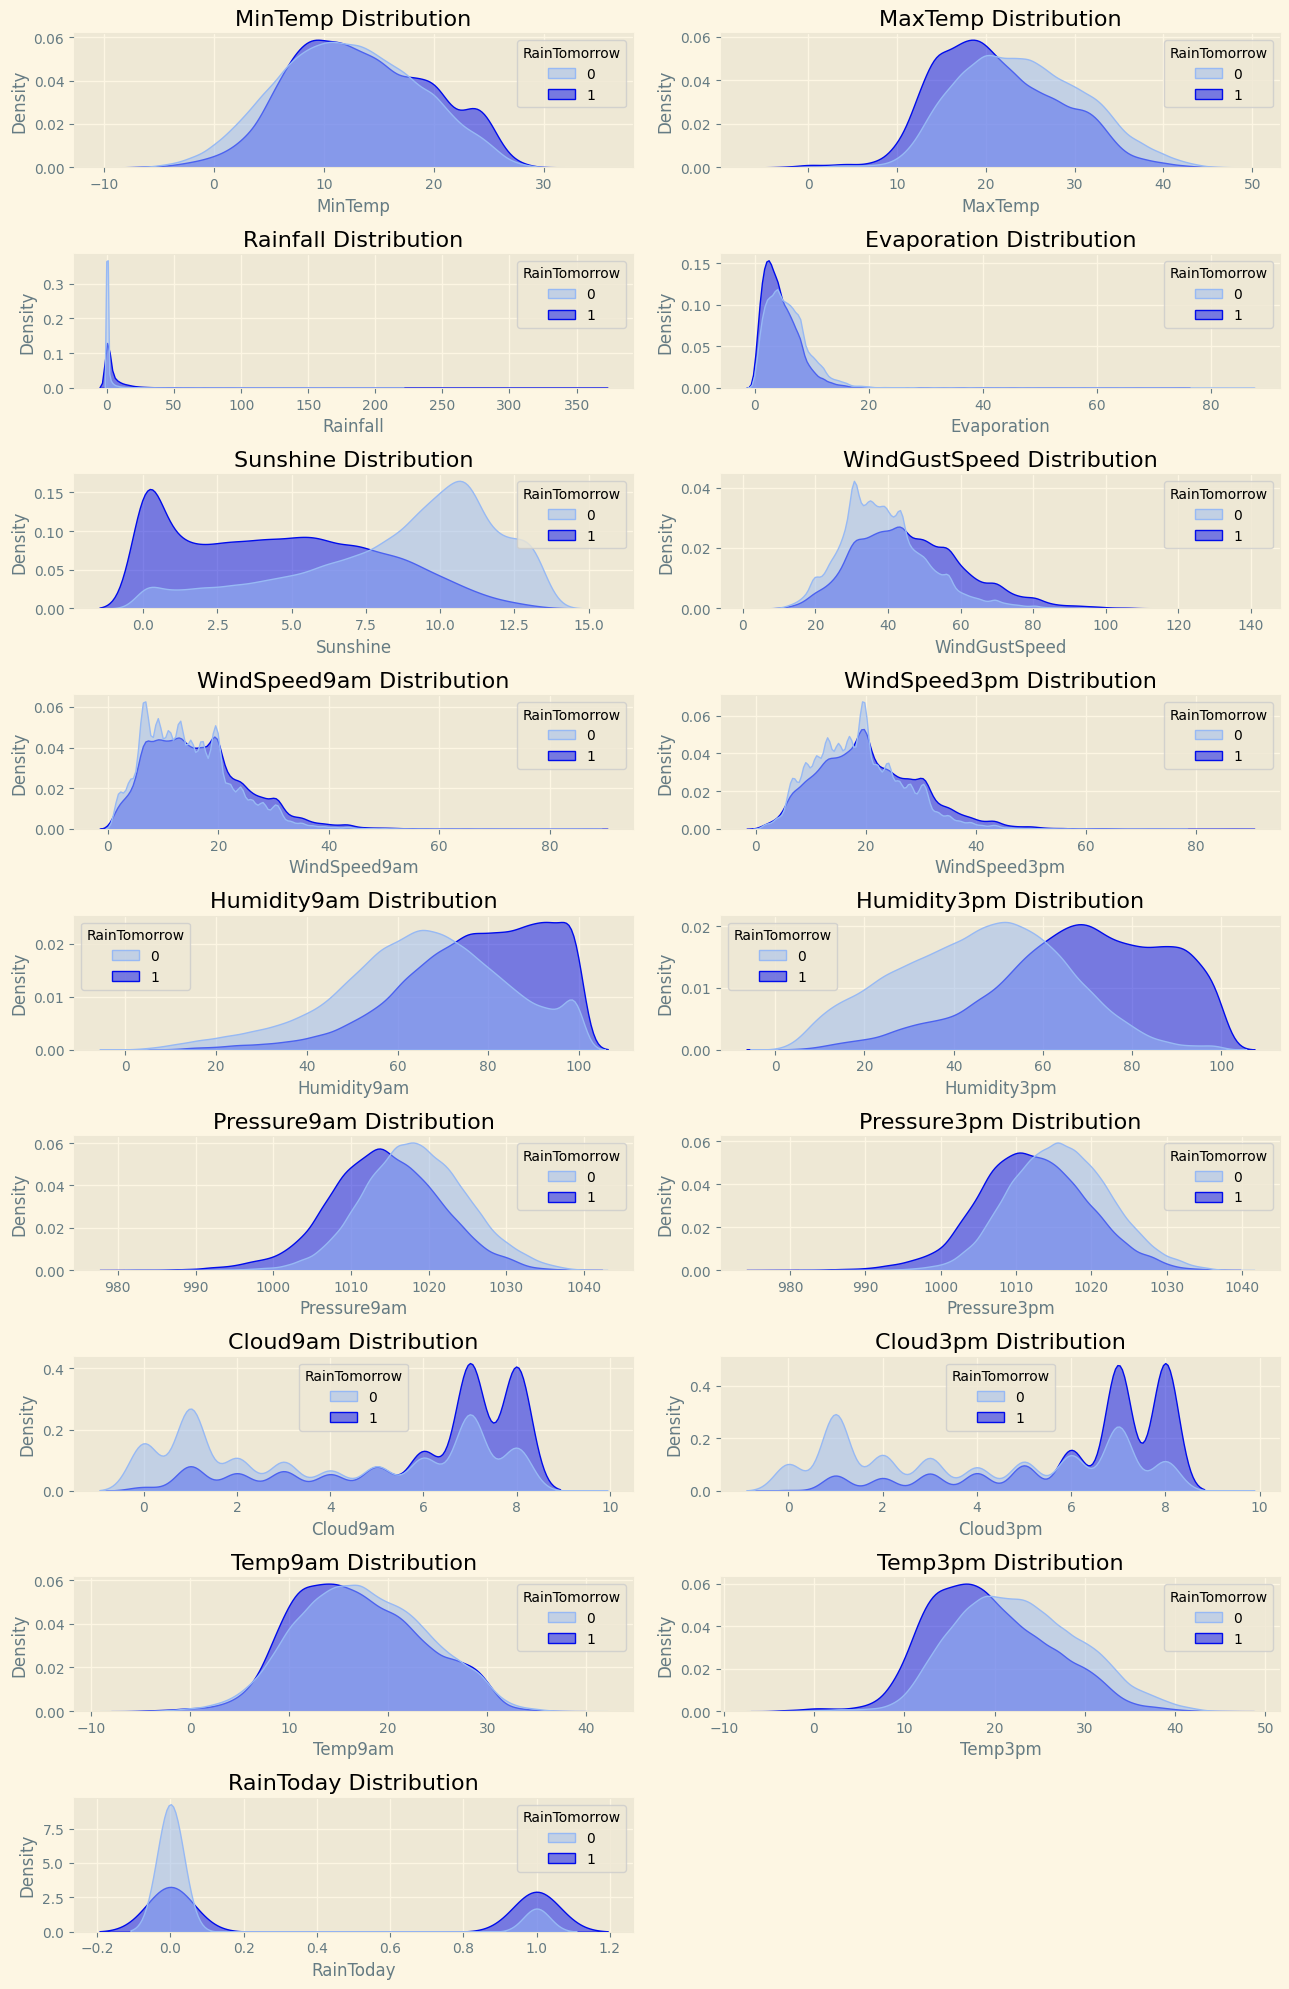

In [67]:
# Define plot layout
n_cols = 2
n_rows = (len(numerical_cols) + 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(13, 20))
axes = axes.flatten()  # Flatten for easier indexing

# Plot each numerical column
for idx, column in enumerate(numerical_cols):
    ax = axes[idx]
    sns.kdeplot(
        data=rain_df, x=column, hue="RainTomorrow", fill=True, common_norm=False,
        palette={1: "#000CEB", 0: "#97B9F4"}, alpha=0.5, ax=ax
    )
    ax.set_title(f"{column} Distribution")
    ax.set_xlabel(column)
    ax.set_ylabel("Density")

# Remove any unused axes
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## Correlation

In [68]:
cm = rain_df[numerical_cols + target_col].corr()

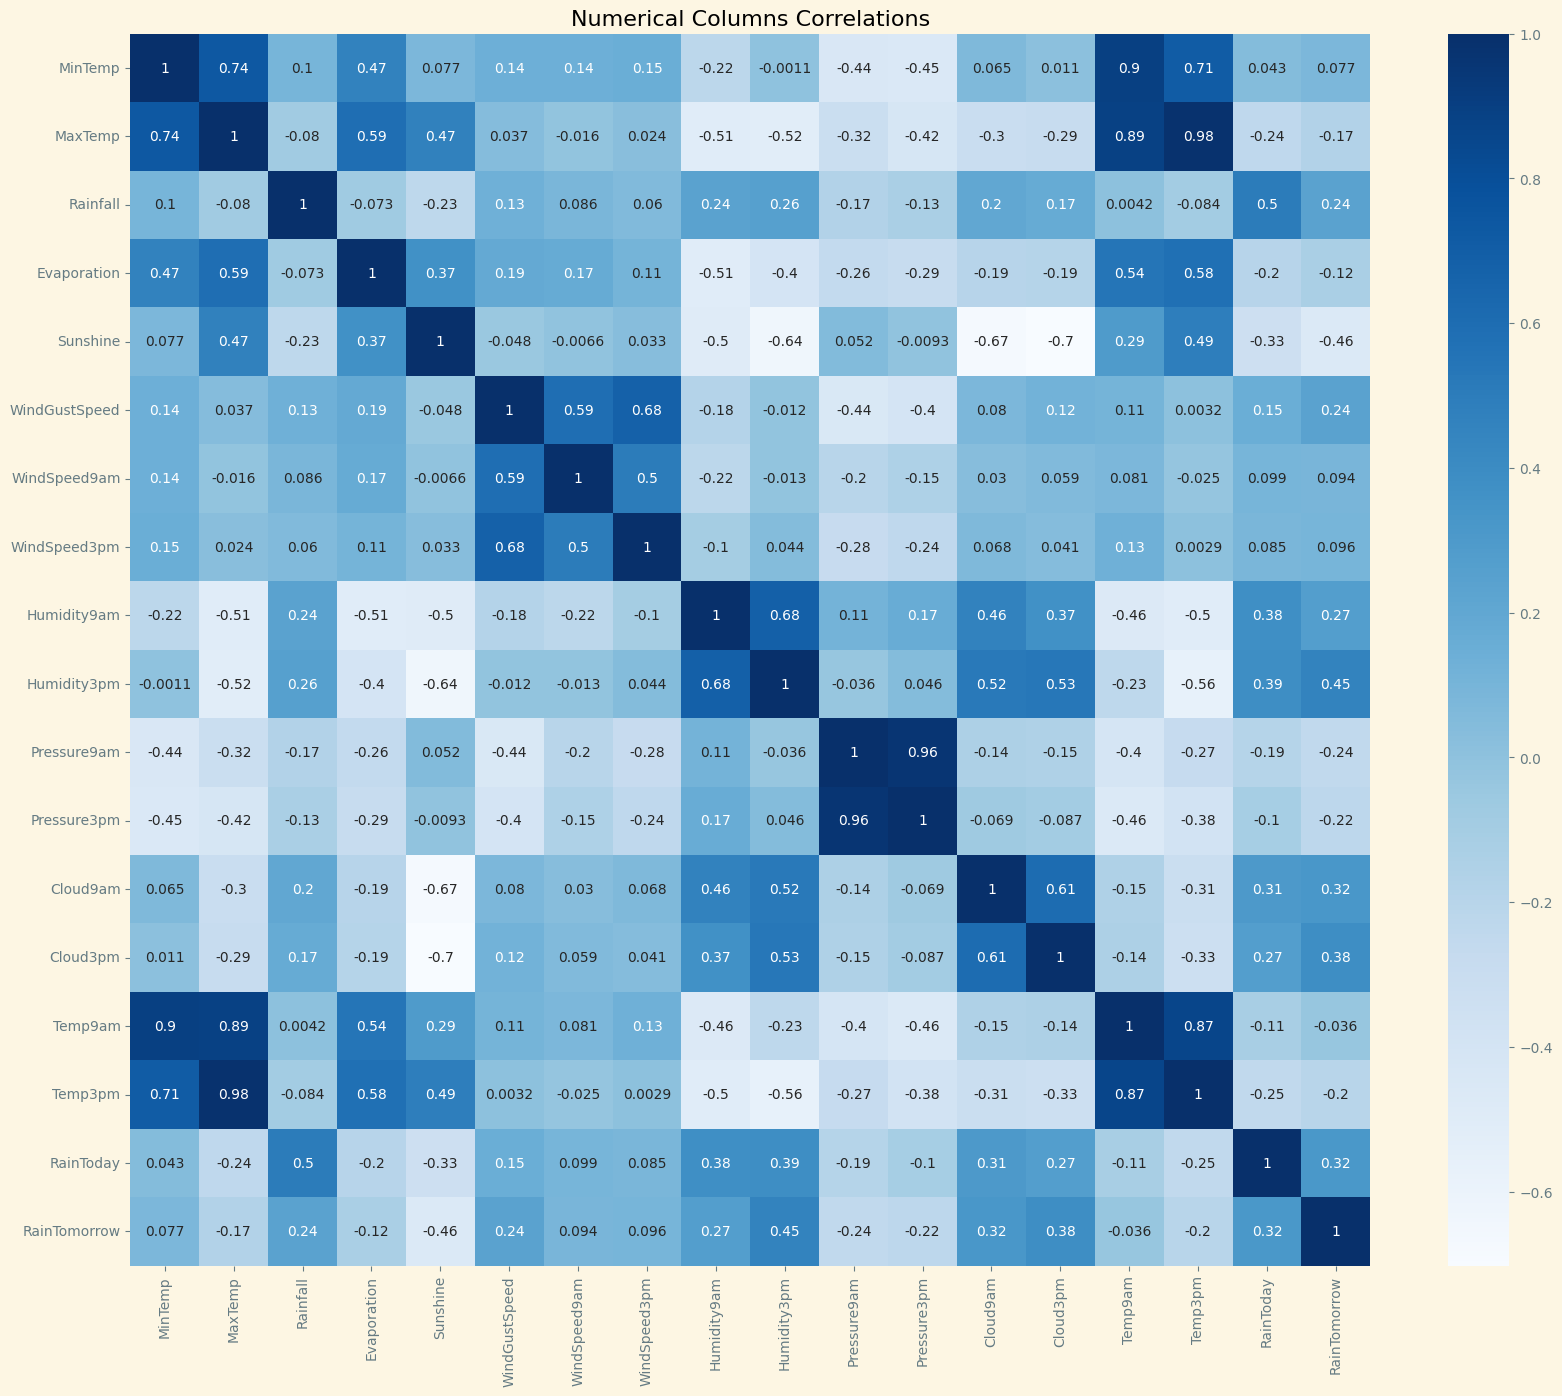

In [69]:
fig, ax = plt.subplots(figsize=(20, 16))

sns.heatmap(data=cm, annot=True, cmap="Blues", ax=ax)

plt.title("Numerical Columns Correlations")
plt.show()

>As you can see MinTemp and Temp9am has a very low correlation with RainTomorrow and have a strong correlation with Temp3pm so these columns are useless

>They can be dropped to:

* reduce noise

* Prevent overfitting

* Improve model generalization

## Drop MinTemp and MaxTemp, Temp9am

In [70]:
useless_features = ["MinTemp", "MaxTemp", "Temp9am"]

# Remove them from numerical_cols and scalar_cols
numerical_cols = [col for col in numerical_cols if col not in useless_features]
scalar_cols = [col for col in scalar_cols if col not in useless_features]

# **Split Train and Test**

In [71]:
years = pd.to_datetime(rain_df["Date"]).dt.year

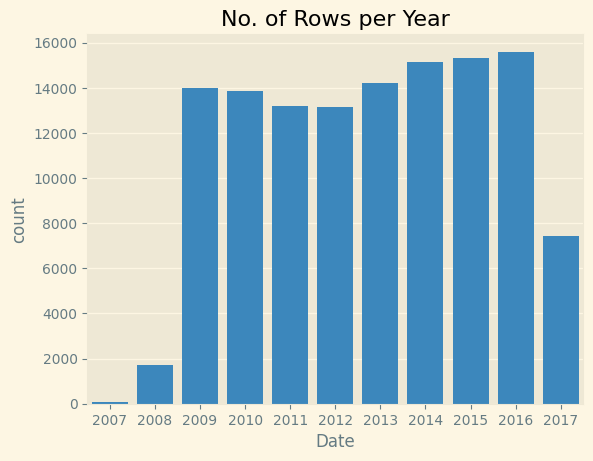

In [72]:
plt.title('No. of Rows per Year')
sns.countplot(x=years);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [73]:
X_train = rain_df[numerical_cols + categorical_cols][years <= 2015].copy()
y_train = rain_df[target_col][years <= 2015].copy()
X_test = rain_df[numerical_cols + categorical_cols][years > 2015].copy()
y_test = rain_df[target_col][years > 2015].copy()

In [74]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100696, 18)
(100696, 1)
(23014, 18)
(23014, 1)


# **Imputer**

In [75]:
imputer.fit(X_train[numerical_cols])

SimpleImputer()

In [76]:
X_train[numerical_cols] = imputer.transform(X_train[numerical_cols])
X_test[numerical_cols] = imputer.transform(X_test[numerical_cols])

In [77]:
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(np.int64(0), np.int64(0))

# **One Hot Encoding**

In [78]:
encoder.fit(X_train[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [79]:
encoder.categories_

[array(['Adelaide', 'Albury', 'AliceSprings', 'BadgerysCreek', 'Ballarat',
        'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Nhil',
        'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF', 'Penrith',
        'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE'

In [80]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Location_Witchcliffe', 'Location_Wollongong',

In [81]:
print(X_train.columns.tolist())

['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [82]:
%%capture
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])

In [83]:
print(X_train.columns.tolist())

['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location_Adelaide', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_Salmon

# **Declare Input**

In [84]:
input_cols = numerical_cols + encoded_cols
print(input_cols)

['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Location_Adelaide', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Lo

# **OverSampling**
There's no use in a classifier that is optimized for balanced classes if in reality the classes are just as imbalanced as your data.

In [85]:
X_train_oversampled, y_train_oversampled = RandomOverSampler().fit_resample(X_train[input_cols], y_train)

# **Normalizatiom**

In [86]:
scalar_model = scalar().fit(X_train[numerical_cols])

In [87]:
X_train[numerical_cols] = scalar_model.transform(X_train[numerical_cols])
X_test[numerical_cols] = scalar_model.transform(X_test[numerical_cols])

X_train_oversampled[numerical_cols] = scalar_model.transform(X_train_oversampled[numerical_cols])

In [88]:
X_train.describe()

,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
count,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,1.006960e+05,...,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000,100696.000000
mean,-4.516042e-17,-1.806417e-17,6.937769e-16,2.246731e-16,9.032084e-18,-1.089495e-16,-2.754786e-16,1.445133e-16,2.697996e-14,-5.602150e-15,...,0.054530,0.058354,0.070936,0.073042,0.068513,0.058503,0.065832,0.072446,0.063478,0.068374
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,...,0.227063,0.234413,0.256720,0.260206,0.252626,0.234693,0.247989,0.259226,0.243822,0.252388
min,-2.759382e-01,-1.689945e+00,-2.655393e+00,-2.526602e+00,-1.568914e+00,-2.013631e+00,-3.534141e+00,-2.422938e+00,-5.460780e+00,-5.378343e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.759382e-01,-4.645490e-01,-5.187508e-03,-7.350876e-01,-7.320064e-01,-7.338381e-01,-5.953880e-01,-6.993096e-01,-6.334810e-01,-6.418350e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.759382e-01,-2.720926e-16,6.113909e-16,-1.379161e-01,-2.537738e-01,-3.576908e-02,3.434472e-02,1.886914e-02,1.678288e-14,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.823485e-01,8.687932e-02,5.799227e-01,5.339019e-01,5.831334e-01,5.459551e-01,7.165551e-01,6.891693e-01,6.360838e-01,6.391075e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.272851e+01,2.355322e+01,2.335253e+00,7.028142e+00,8.593531e+00,7.875680e+00,1.713632e+00,2.364920e+00,3.470461e+00,3.647833e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# .
# **Train and Explore Models**

# .
| F1-Score Range | Interpretation                                                                                                               |
| -------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| **0.9 – 1.0**  | Excellent (rare, but achievable in well-defined tasks or with imbalanced classes where the positive class is easy to detect) |
| **0.8 – 0.9**  | Very good                                                                                                                    |
| **0.7 – 0.8**  | Good                                                                                                                         |
| **0.6 – 0.7**  | Fair/Acceptable                                                                                                              |
| **0.5 – 0.6**  | Weak (better than random, but may need improvement)                                                                          |
| **< 0.5**      | Poor (often indicates imbalance, noise, or model issues)                                                                     |


# **Overfitting**
When model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

# **DecisionTree**
We can use DecisionTreeClassifier from sklearn.tree to train a decision tree.

## About


A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="360">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

## Train and Test

In [89]:
%%time
for X, y, title in [(X_train[input_cols], y_train, "Imbalanced"), (X_train_oversampled, y_train_oversampled, "Balanced")]:
    print(title)

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X, y.iloc[:, 0])

    print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=dt_model.predict(X_test[input_cols])))
    print("Train\n", classification_report(y_true=y.iloc[:, 0], y_pred=dt_model.predict(X)))
    print("=" * 75)

Imbalanced
Test
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     17770
           1       0.52      0.54      0.53      5244

    accuracy                           0.78     23014
   macro avg       0.69      0.70      0.69     23014
weighted avg       0.78      0.78      0.78     23014

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     78548
           1       1.00      1.00      1.00     22148

    accuracy                           1.00    100696
   macro avg       1.00      1.00      1.00    100696
weighted avg       1.00      1.00      1.00    100696

Balanced
Test
               precision    recall  f1-score   support

           0       0.86      0.85      0.86     17770
           1       0.51      0.53      0.52      5244

    accuracy                           0.78     23014
   macro avg       0.69      0.69      0.69     23014
weighted avg       0.78      0.78  

>The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too.

>We can make predictions and compute accuracy in one step using `model.score`

>It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

In [ ]:
dt_model.tree_.max_depth

53

## You can prevent overfitting by decreasing max_depth

In [ ]:
%%time
for X, y, title in [(X_train[input_cols], y_train, "Imbalanced"), (X_train_oversampled, y_train_oversampled, "Balanced")]:
    print(title)

    dt_model_2 = DecisionTreeClassifier(random_state=42, max_depth=12)
    dt_model_2.fit(X, y.iloc[:, 0])

    print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=dt_model_2.predict(X_test[input_cols])))
    print("Train\n", classification_report(y_true=y.iloc[:, 0], y_pred=dt_model_2.predict(X)))
    print("=" * 75)

Imbalanced
Test
               precision    recall  f1-score   support

           0       0.86      0.93      0.90     17770
           1       0.68      0.50      0.57      5244

    accuracy                           0.83     23014
   macro avg       0.77      0.71      0.73     23014
weighted avg       0.82      0.83      0.82     23014

Train
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     78548
           1       0.84      0.64      0.73     22148

    accuracy                           0.89    100696
   macro avg       0.87      0.80      0.83    100696
weighted avg       0.89      0.89      0.89    100696

Balanced
Test
               precision    recall  f1-score   support

           0       0.90      0.81      0.85     17770
           1       0.51      0.69      0.59      5244

    accuracy                           0.78     23014
   macro avg       0.71      0.75      0.72     23014
weighted avg       0.81      0.78  

## Visualize and Explore Trained Decision Tree Model
We can visualize the decision tree learned from the training data.

### plot_tree

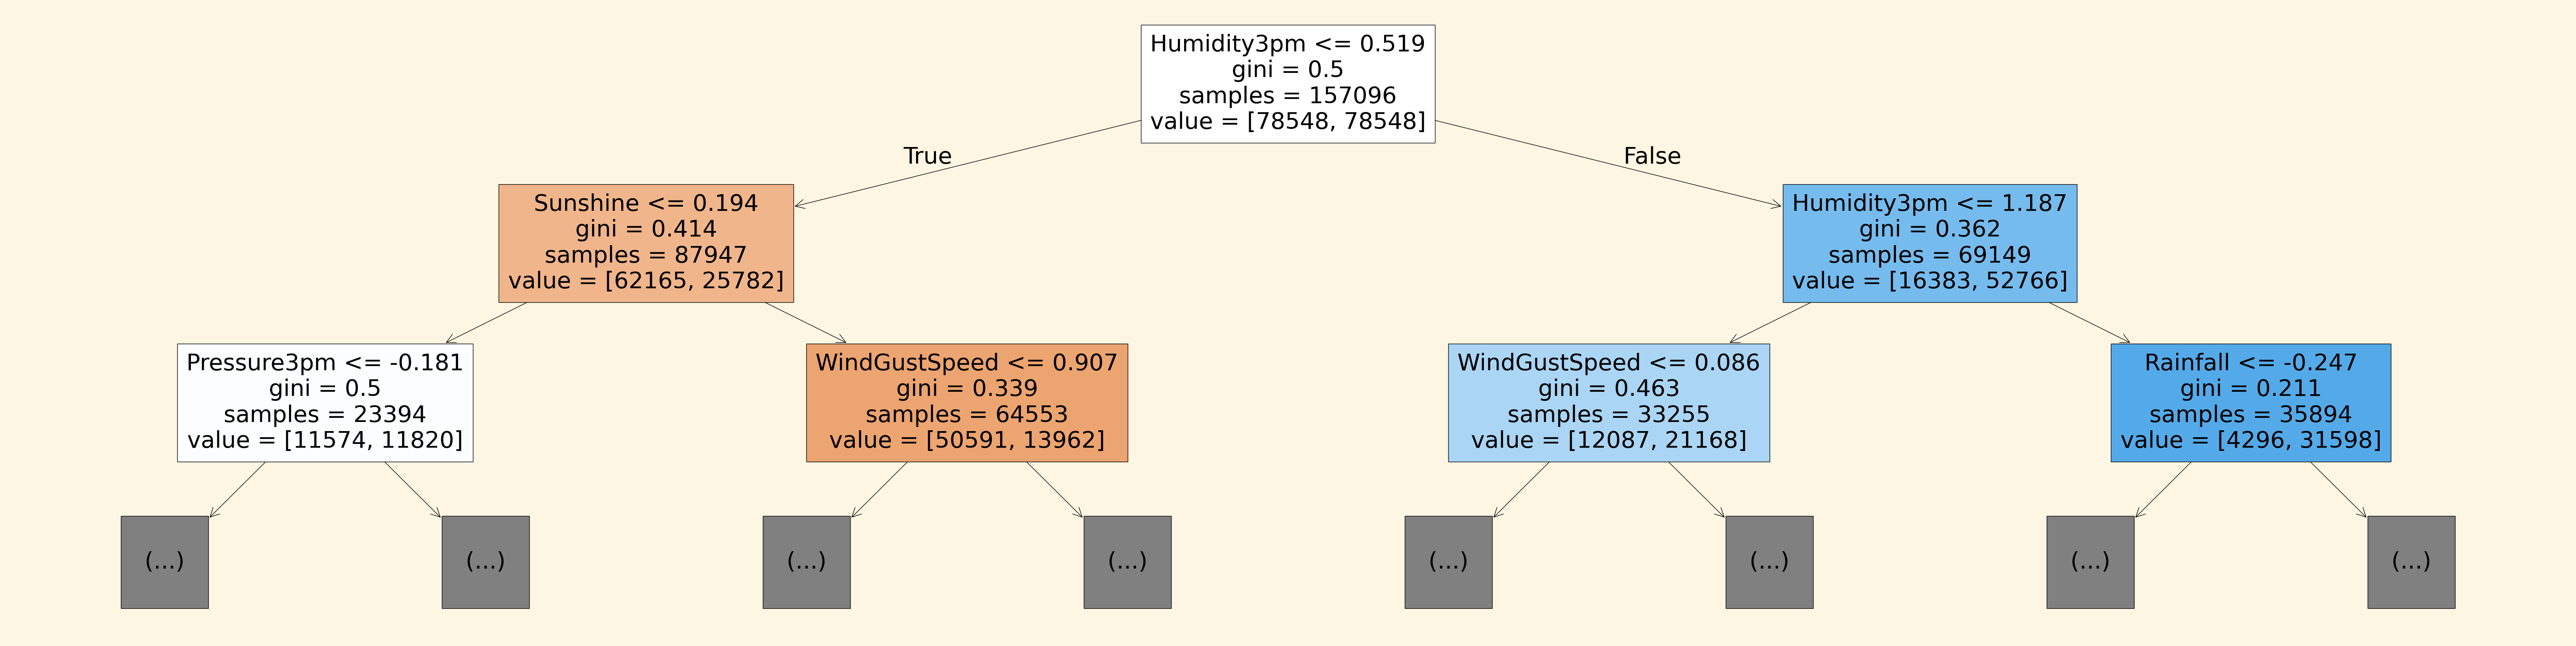

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(dt_model, feature_names=X_train_oversampled.columns, max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

### Check the depth of the tree that was created

In [ ]:
dt_model.tree_.max_depth

53

### Display the tree as text, which can be easier to follow for deeper trees.

In [ ]:
tree_text = export_text(dt_model, max_depth=10, feature_names=input_cols)
print(tree_text[:5000])

|--- Humidity3pm <= 0.52
|   |--- Sunshine <= 0.19
|   |   |--- Pressure3pm <= -0.18
|   |   |   |--- WindGustSpeed <= 0.31
|   |   |   |   |--- Humidity3pm <= -1.05
|   |   |   |   |   |--- WindGustSpeed <= -0.21
|   |   |   |   |   |   |--- WindDir3pm_S <= 0.50
|   |   |   |   |   |   |   |--- WindGustDir_WSW <= 0.50
|   |   |   |   |   |   |   |   |--- WindGustDir_ESE <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- WindGustDir_ESE >  0.50
|   |   |   |   |   |   |   |   |   |--- Pressure9am <= -0.31
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- Pressure9am >  -0.31
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- WindGustDir_WSW >  0.50
|   |   |   |   |   |   |   |   |--- Humidity9am <= -2.03
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Humidity9am >  -2.03
|   |   |   |   |   |   |   |   |   |--- class: 0
| 

> **EXERCISE**: Based on the above discussion, can you explain why the training accuracy is 100% whereas the validation accuracy is lower?

The model create trees for all possibilities(Learn all samples).

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [ ]:
dt_model.feature_importances_

array([3.43071948e-02, 2.18630392e-02, 7.03443041e-02, 6.76863063e-02,
       2.94918299e-02, 3.18709245e-02, 4.35759083e-02, 3.02438937e-01,
       3.84900416e-02, 6.90860830e-02, 1.42586383e-02, 1.79789717e-02,
       5.59031936e-02, 8.42889576e-04, 1.69713361e-03, 1.72491435e-03,
       2.92954054e-04, 1.22851882e-03, 1.48044735e-03, 1.60014086e-03,
       2.31979800e-03, 1.43055416e-03, 1.69298458e-03, 1.70975889e-03,
       2.28268641e-03, 1.24011000e-03, 7.77046811e-04, 1.79128601e-03,
       1.62293574e-03, 1.82719803e-04, 1.43567163e-03, 8.43780946e-04,
       1.23641515e-03, 1.36942923e-03, 9.48722512e-04, 1.32994756e-03,
       6.55222965e-04, 8.96992845e-04, 2.46559949e-03, 2.07397443e-03,
       1.56457674e-03, 4.52474668e-04, 8.37777511e-04, 1.01852008e-03,
       6.98563471e-04, 1.64569533e-03, 1.19435339e-03, 2.47388621e-03,
       1.43105788e-03, 1.27580019e-03, 1.38689689e-03, 1.34289557e-03,
       1.03143841e-03, 4.72435548e-04, 1.03491873e-03, 1.82296400e-03,
      

>Let's turn this into a dataframe and visualize the most important features.

In [ ]:
importance_df = pd.DataFrame({
    'feature': input_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df.head(10)

,feature,importance
7,Humidity3pm,0.302439
2,Sunshine,0.070344
9,Pressure3pm,0.069086
3,WindGustSpeed,0.067686
12,Temp3pm,0.055903
6,Humidity9am,0.043576
8,Pressure9am,0.038490
0,Rainfall,0.034307
5,WindSpeed3pm,0.031871
4,WindSpeed9am,0.029492


In [ ]:
importance_df[importance_df['feature'] == "RainToday"]

,feature,importance
13,RainToday,0.000843


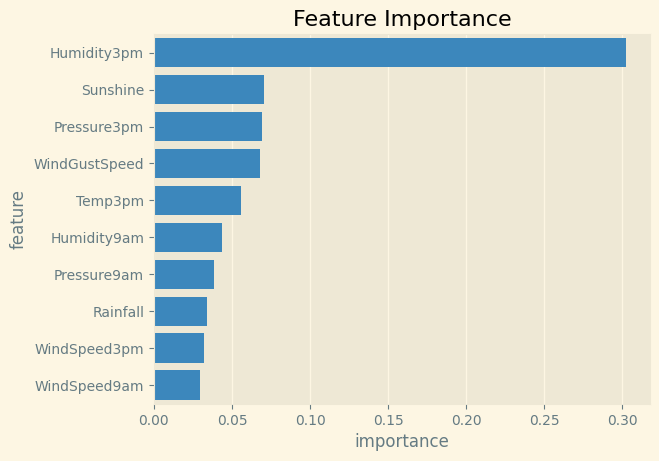

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting.(regularization)

The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [ ]:
?DecisionTreeClassifier

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### **max_depth**

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [ ]:
temp_model = DecisionTreeClassifier(random_state=42, max_depth=3)
temp_model.fit(X_train[input_cols], y_train.iloc[:, 0])

print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=temp_model.predict(X_test[input_cols])))
print("Train\n", classification_report(y_true=y_train.iloc[:, 0], y_pred=temp_model.predict(X_train[input_cols])))

Test
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     17770
           1       0.73      0.39      0.51      5244

    accuracy                           0.83     23014
   macro avg       0.79      0.67      0.70     23014
weighted avg       0.82      0.83      0.81     23014

Train
               precision    recall  f1-score   support

           0       0.85      0.96      0.90     78548
           1       0.74      0.39      0.51     22148

    accuracy                           0.84    100696
   macro avg       0.79      0.68      0.71    100696
weighted avg       0.82      0.84      0.81    100696



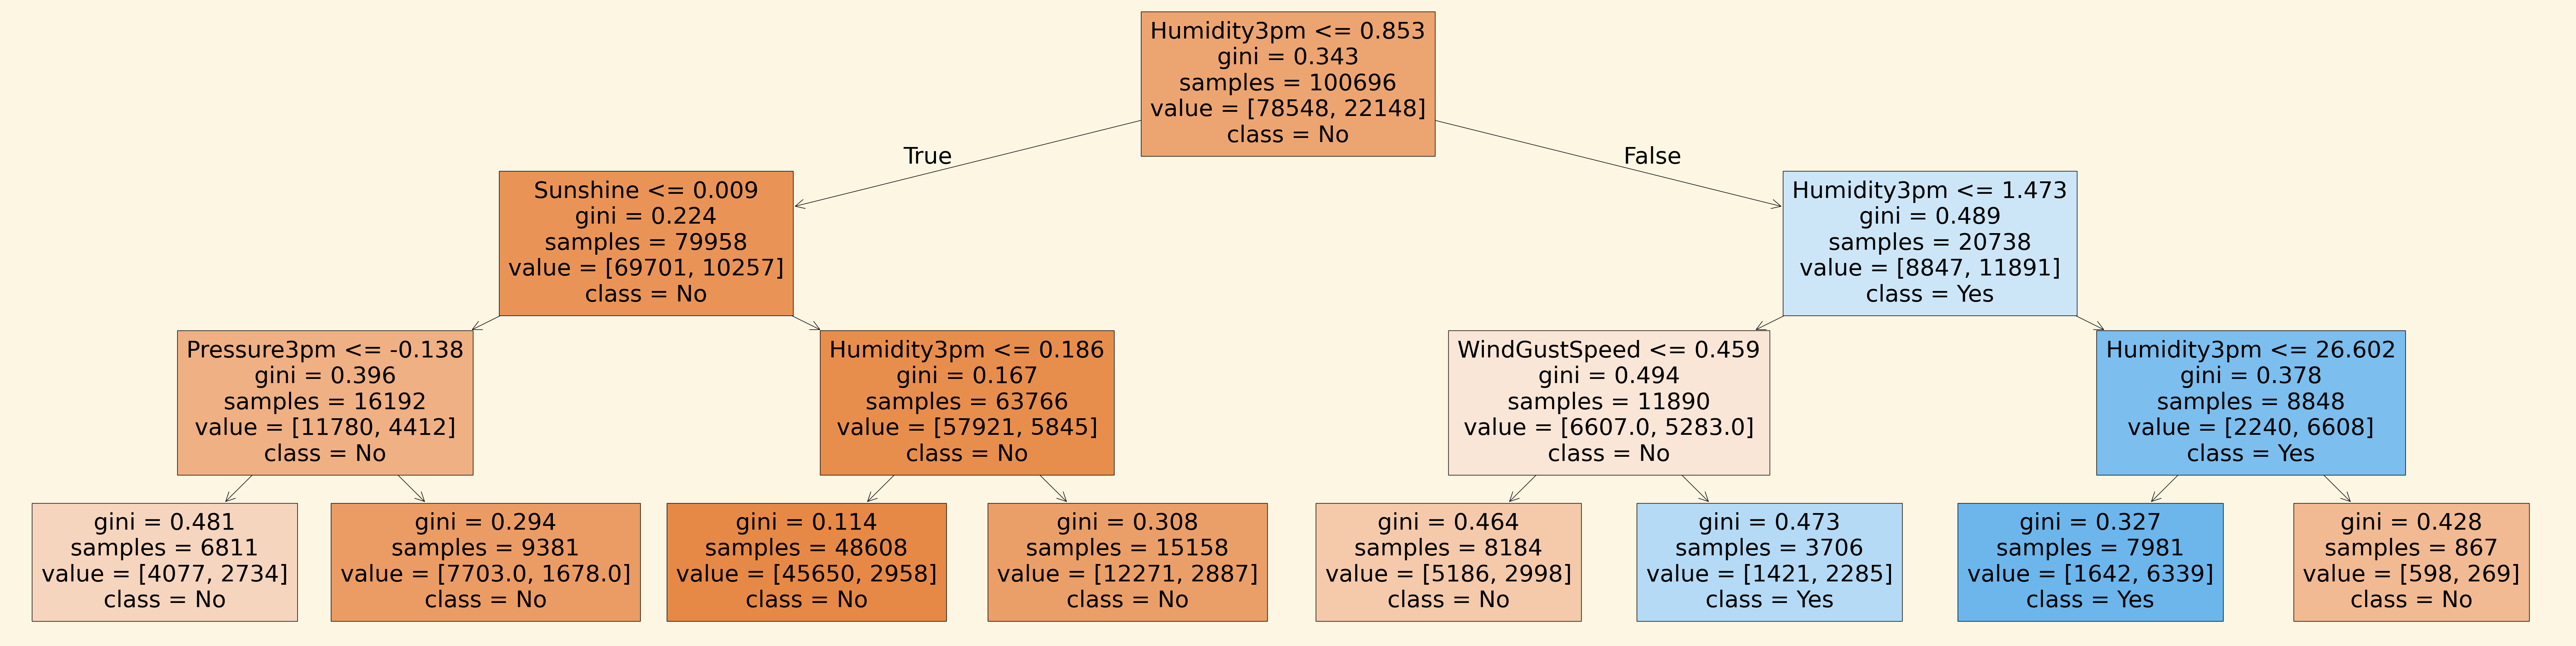

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(temp_model, feature_names=X_train_oversampled.columns, max_depth=3, filled=True, class_names=list(map(lambda x: "Yes" if x==1 else "No", temp_model.classes_)));

> **EXERCISE**: Study the decision tree diagram carefully and understand what each of the terms `gini`, `samples`, `value` and `class` mean.

In [ ]:
print(export_text(temp_model, feature_names=input_cols))

|--- Humidity3pm <= 0.85
|   |--- Sunshine <= 0.01
|   |   |--- Pressure3pm <= -0.14
|   |   |   |--- class: 0
|   |   |--- Pressure3pm >  -0.14
|   |   |   |--- class: 0
|   |--- Sunshine >  0.01
|   |   |--- Humidity3pm <= 0.19
|   |   |   |--- class: 0
|   |   |--- Humidity3pm >  0.19
|   |   |   |--- class: 0
|--- Humidity3pm >  0.85
|   |--- Humidity3pm <= 1.47
|   |   |--- WindGustSpeed <= 0.46
|   |   |   |--- class: 0
|   |   |--- WindGustSpeed >  0.46
|   |   |   |--- class: 1
|   |--- Humidity3pm >  1.47
|   |   |--- Humidity3pm <= 26.60
|   |   |   |--- class: 1
|   |   |--- Humidity3pm >  26.60
|   |   |   |--- class: 0



### **Let's experiment with different depths using a helper function**
max_depth = 7

In [ ]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train[input_cols], y_train.iloc[:, 0])
    train_acc = 1 - model.score(X_train[input_cols], y_train.iloc[:, 0])
    val_acc = 1 - model.score(X_test[input_cols], y_test.iloc[:, 0])
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [ ]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 35 s, sys: 1.12 s, total: 36.1 s
Wall time: 36.2 s


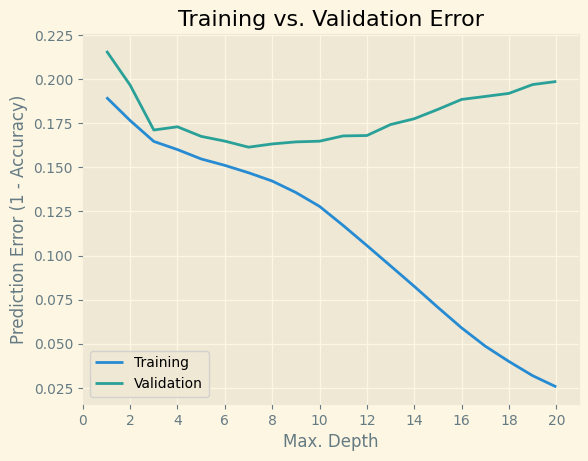

In [ ]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

In [ ]:
temp_model = DecisionTreeClassifier(random_state=42, max_depth=7)
temp_model.fit(X_train[input_cols], y_train.iloc[:, 0])

print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=temp_model.predict(X_test[input_cols])))
print("Train\n", classification_report(y_true=y_train.iloc[:, 0], y_pred=temp_model.predict(X_train[input_cols])))

Test
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     17770
           1       0.72      0.47      0.57      5244

    accuracy                           0.84     23014
   macro avg       0.79      0.71      0.74     23014
weighted avg       0.83      0.84      0.83     23014

Train
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     78548
           1       0.75      0.49      0.60     22148

    accuracy                           0.85    100696
   macro avg       0.81      0.72      0.75    100696
weighted avg       0.84      0.85      0.84    100696



### **max_leaf_nodes**
Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths

In [ ]:
temp_model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=128)
temp_model.fit(X_train[input_cols], y_train.iloc[:, 0])

print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=temp_model.predict(X_test[input_cols])))
print("Train\n", classification_report(y_true=y_train.iloc[:, 0], y_pred=temp_model.predict(X_train[input_cols])))

temp_model.tree_.max_depth

Test
               precision    recall  f1-score   support

           0       0.86      0.94      0.90     17770
           1       0.71      0.49      0.58      5244

    accuracy                           0.84     23014
   macro avg       0.78      0.71      0.74     23014
weighted avg       0.83      0.84      0.83     23014

Train
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     78548
           1       0.74      0.52      0.61     22148

    accuracy                           0.85    100696
   macro avg       0.81      0.74      0.76    100696
weighted avg       0.85      0.85      0.84    100696



10

# **RandomForest**

## About

### Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest.

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also known as the "wisdom of the crowd" in common parlance:

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

## Train and Test

n_jobs=-1 allows the random forest to use multiple parallel workers to train decision tree

In [90]:
%%time
for X, y, title in [(X_train[input_cols], y_train, "Imbalanced"), (X_train_oversampled, y_train_oversampled, "Balanced")]:
    print(title)

    rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=101, random_state=42)
    rf_model.fit(X, y.iloc[:, 0])

    print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=rf_model.predict(X_test[input_cols])))
    print("Train\n", classification_report(y_true=y.iloc[:, 0], y_pred=rf_model.predict(X)))
    print("=" * 75)

Imbalanced
Test
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     17770
           1       0.76      0.50      0.60      5244

    accuracy                           0.85     23014
   macro avg       0.81      0.72      0.75     23014
weighted avg       0.84      0.85      0.84     23014

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     78548
           1       1.00      1.00      1.00     22148

    accuracy                           1.00    100696
   macro avg       1.00      1.00      1.00    100696
weighted avg       1.00      1.00      1.00    100696

Balanced
Test
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     17770
           1       0.69      0.59      0.64      5244

    accuracy                           0.85     23014
   macro avg       0.79      0.76      0.77     23014
weighted avg       0.84      0.85  

Once again, the training accuracy is 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="480">


## Explore Trained Random Forest Model

### We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [ ]:
rf_probs = rf_model.predict_proba(X_train_oversampled)
rf_probs

array([[0.95049505, 0.04950495],
       [0.99009901, 0.00990099],
       [0.96039604, 0.03960396],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

first prob -> 94% of decision trees predict No and 6% predict Yes

### We can can access individual decision trees using `model.estimators_`

In [ ]:
len(rf_model.estimators_)

101

In [ ]:
rf_model.estimators_[2]

DecisionTreeClassifier(max_features='sqrt', random_state=1935803228)

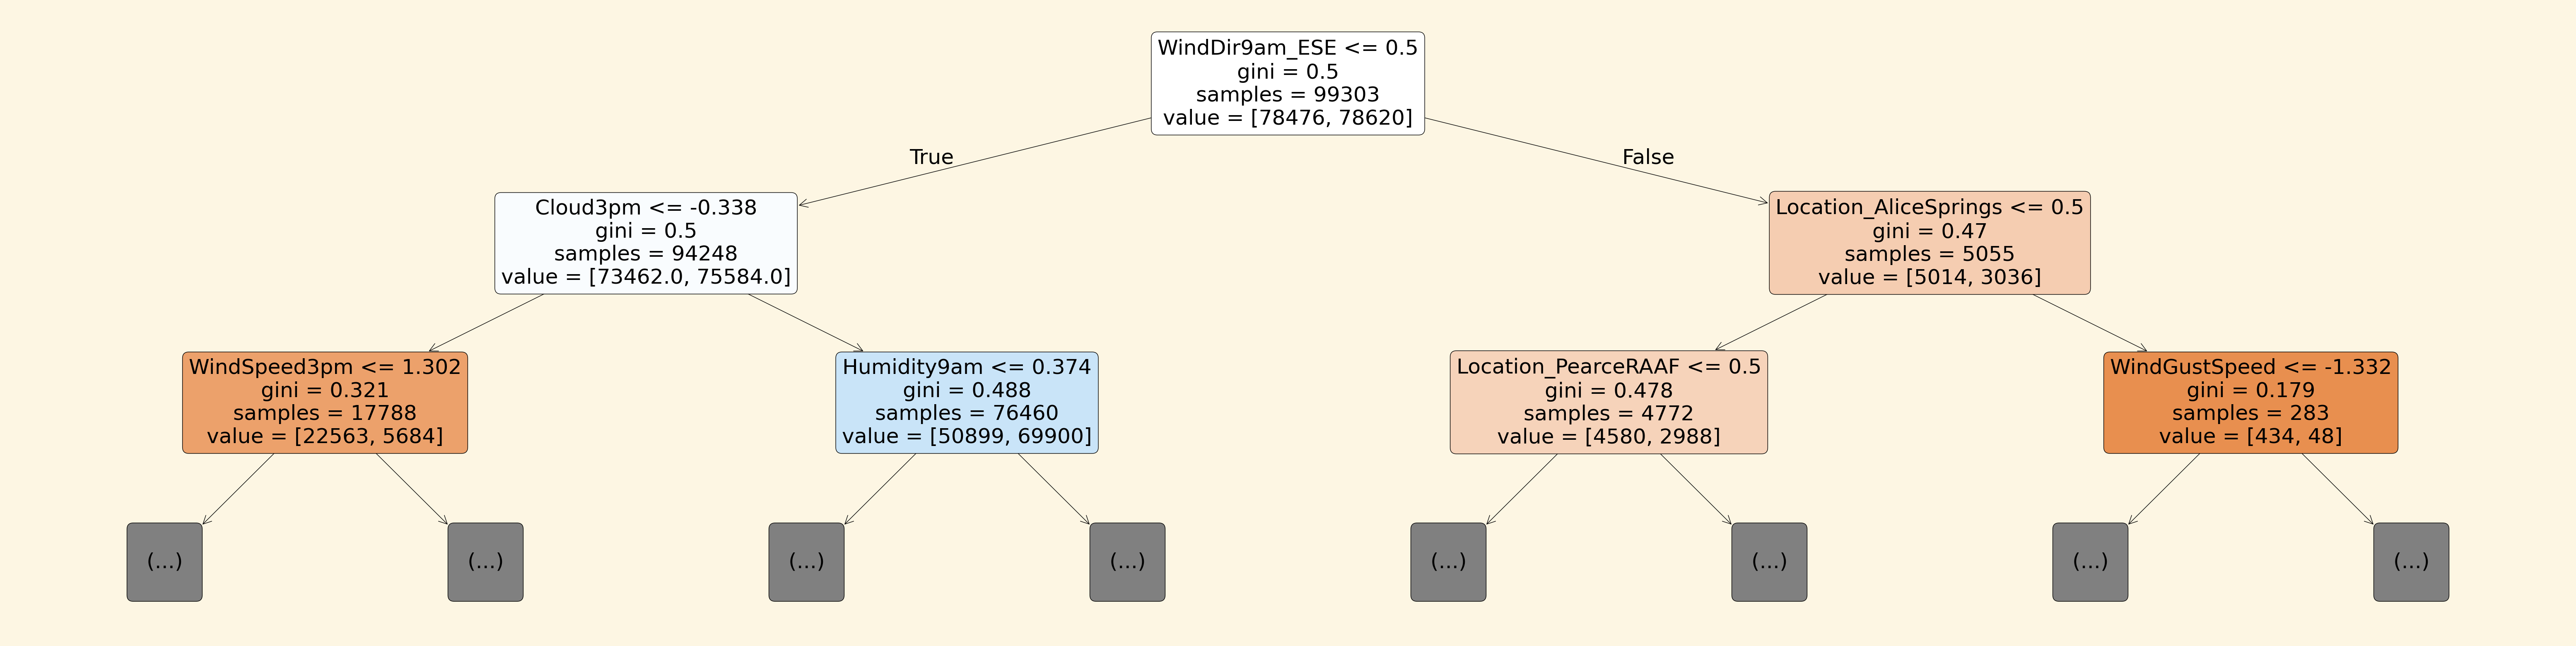

In [ ]:
plt.figure(figsize=(80, 20))
plot_tree(decision_tree=rf_model.estimators_[2], max_depth=2, feature_names=input_cols, filled=True, rounded=True)
plt.show()

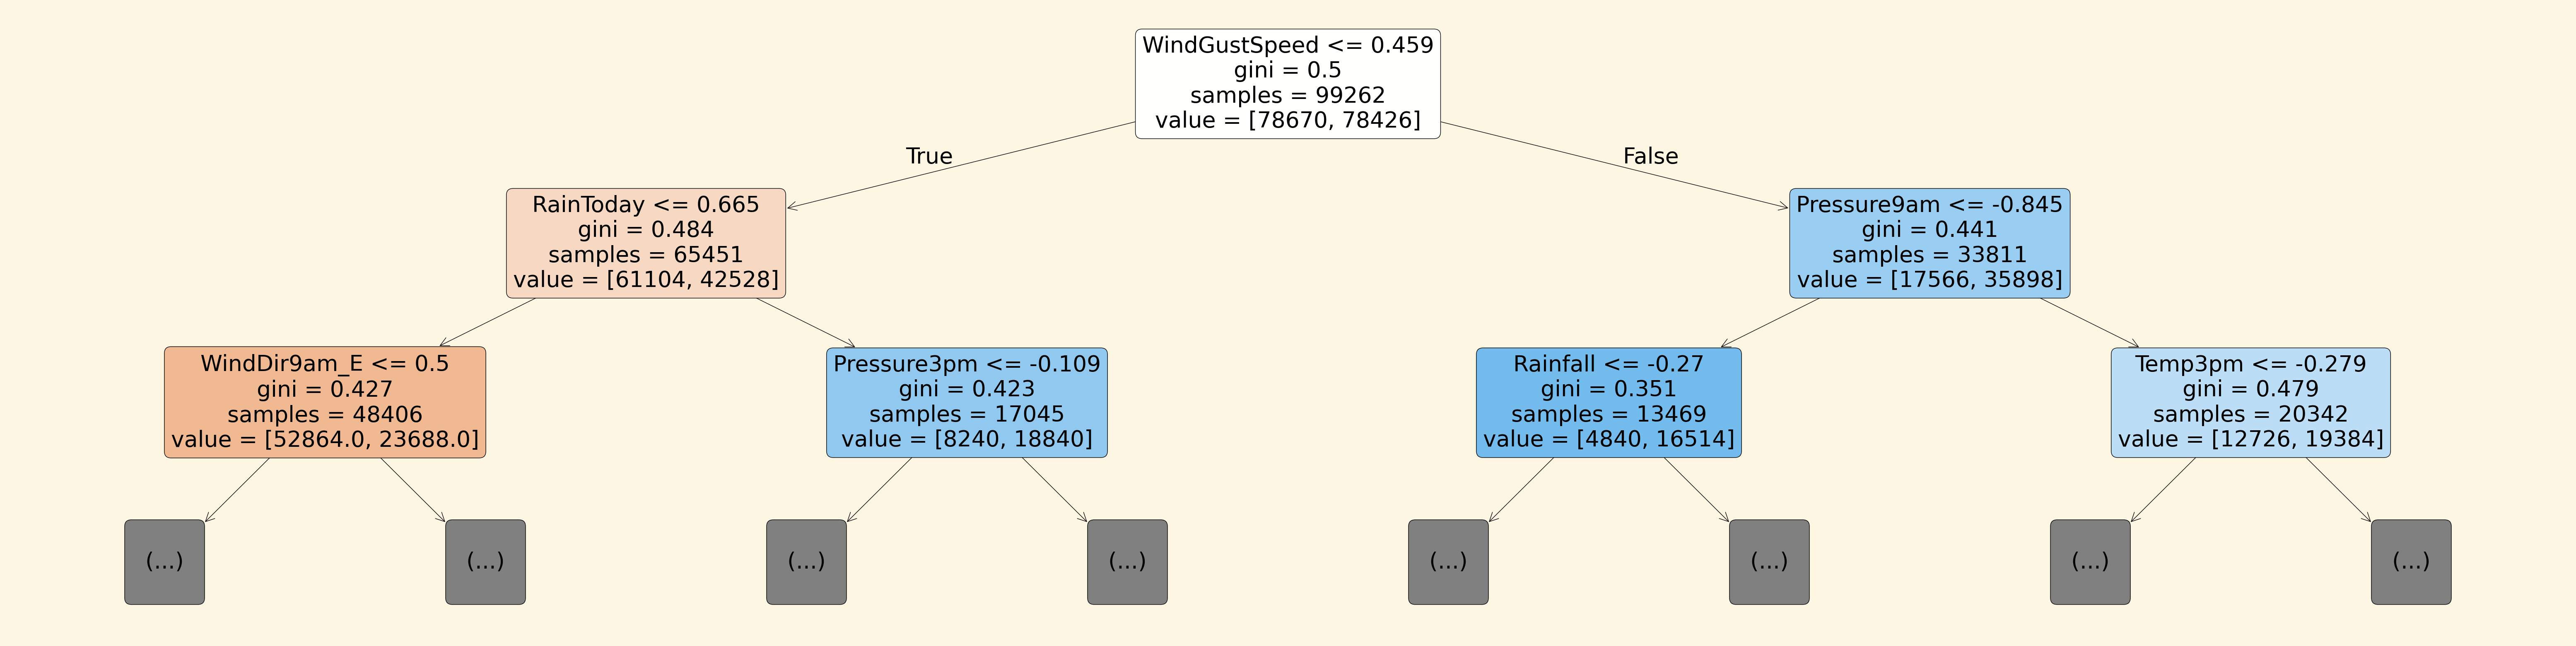

In [ ]:
plt.figure(figsize=(80, 20))
plot_tree(decision_tree=rf_model.estimators_[20], max_depth=2, feature_names=input_cols, filled=True, rounded=True)
plt.show()

### EXERCISE: Verify that none of the individual decision trees have a better validation accuracy than the random forest.

In [ ]:
%%capture
rf_model_score = rf_model.score(X_test.loc[:, input_cols], y_test)
counter = 0

for dt in rf_model.estimators_:
    if rf_model_score < dt.score(X_test.loc[:, input_cols], y_test):
        counter += 1

In [ ]:
print(f"There are {counter} decision trees that better than random forest model.")

There are 0 decision trees that better than random forest model.


### Feature Importance

In [ ]:
rf_importance_df = pd.DataFrame(data={
    "feature": input_cols,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)

In [ ]:
rf_importance_df.head()

,feature,importance
7,Humidity3pm,0.156872
6,Humidity9am,0.069836
2,Sunshine,0.064993
3,WindGustSpeed,0.062649
9,Pressure3pm,0.061746


## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees.

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# ?RandomForestClassifier

In [ ]:
def test_params(**params):
    """
    Return train score and test score
    """
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train[input_cols], y_train.iloc[:, 0])
    return model.score(X_train[input_cols], y_train.iloc[:, 0]), model.score(X_test[input_cols], y_test.iloc[:, 0])

### `n_estimators`
it's not cause overfitting

This controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. **As a general rule, try to have as few estimators as needed**.

> **EXERCISE**: Vary the value of `n_estimators` and plot the graph between training error and validation error. What is the optimal value of `n_estimators`?

In [ ]:
n_estimators = list(range(10, 100, 5))
n_scores_train = []
n_scores_test = []

for i, estimator in enumerate(n_estimators):
    temp_model = RandomForestClassifier(n_jobs=-1, n_estimators=estimator, random_state=42).fit(X_train[input_cols], y_train.iloc[:, 0])
    n_scores_train.append(temp_model.score(X_train[input_cols], y_train.iloc[:, 0]))
    n_scores_test.append(temp_model.score(X_test[input_cols], y_test.iloc[:, 0]))

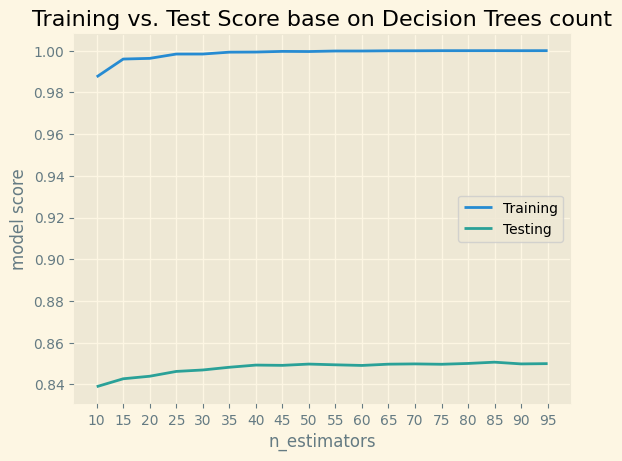

In [ ]:
plt.figure()
plt.plot(n_estimators, n_scores_train)
plt.plot(n_estimators, n_scores_test)
plt.title('Training vs. Test Score base on Decision Trees count')
plt.xticks(n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('model score')
plt.legend(['Training', 'Testing'])

### `max_depth` and `max_leaf_nodes`


These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified, which is why each tree has a training accuracy of 100%. You can specify a `max_depth` to reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function to `max depth`, `max_leaf_nodes` and other hyperparameters easily.

> **EXERCISE**: Vary the value of `max_depth` and plot the graph between training error and validation error. What is the optimal value of `max_depth`? Do the same for `max_leaf_nodes`.

In [ ]:
rf_model.estimators_[0].tree_.max_depth

52

In [ ]:
test_params()

(0.9999801382378645, 0.8490918571304423)

In [ ]:
test_params(max_depth=5)

(0.824243266862636, 0.810506648127227)

In [ ]:
test_params(max_depth=26)

(0.9849845078255343, 0.8490049535065612)

In [ ]:
test_params(max_leaf_nodes=2**5)

(0.8370143799157861, 0.8243677761362649)

The optimal values of `max_depth` and `max_leaf_nodes` lies somewhere between 0 and unbounded.

### `Random fraction of columns`
Instead of picking all columns for every split, we can specify that only a fraction of features be chosen randomly.

by default it use sqrt(n_columns) to pick a fraction of columns


The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'sqrts' instead.

In [ ]:
test_params(max_features="log2")

(0.9999900691189322, 0.8485704353871556)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [ ]:
# if node have 3 or more samples, split it
# if leaf contain less than 2 samples, don't performe splitting
test_params(min_samples_split=5, min_samples_leaf=2)

(0.9529276237387782, 0.8513948031632919)

In [ ]:
# by increasing min_samples_split and  min_samples_leaf model reduces the power of model
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8536783983475014, 0.8373598679064918)

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.



In [ ]:
test_params(min_impurity_decrease=1e-6)

(0.9865635179153095, 0.8497001824976101)

In [ ]:
test_params(min_impurity_decrease=1e-2)

(0.780050846111067, 0.7721386981837143)

### `bootstrap`, `max_samples`

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [ ]:
test_params()

(0.9999801382378645, 0.8490918571304423)

In [ ]:
test_params(bootstrap=False)

(1.0, 0.8500912488050751)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [ ]:
test_params(max_samples=0.9)

(0.9998808294271868, 0.8473972364647606)

### `class_weight`

In [ ]:
rf_model.classes_

array([0, 1], dtype=int8)

In [ ]:
test_params(class_weight="balanced")

(0.9999702073567966, 0.8471799774050578)

In [ ]:
test_params(class_weight={0: 1, 1: 2})

(0.9999801382378645, 0.848831146258799)

### **Put All Together**

In [ ]:
test_params(n_estimators=500,
            max_features=7,
            max_depth=30,
            class_weight={0: 1, 1: 1.5})

(0.993395964089934, 0.8497870861214912)

# **Dummy Models**

In [ ]:
def no_model(y_true) -> None:
    print("No Model\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=np.zeros_like(y_true), zero_division=0.0))

def random_model(y_true):
    print("Random Model\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=np.random.randint(low=0, high=2, size=y_true.shape)))

In [ ]:
no_model(y_test.iloc[:, 0])
random_model(y_test.iloc[:, 0])

No Model
               precision    recall  f1-score   support

           0       0.77      1.00      0.87     17770
           1       0.00      0.00      0.00      5244

    accuracy                           0.77     23014
   macro avg       0.39      0.50      0.44     23014
weighted avg       0.60      0.77      0.67     23014

Random Model
               precision    recall  f1-score   support

           0       0.78      0.51      0.61     17770
           1       0.23      0.50      0.32      5244

    accuracy                           0.50     23014
   macro avg       0.50      0.50      0.46     23014
weighted avg       0.65      0.50      0.54     23014



# **Logistic Regression**

In [91]:
for X, y, title in [(X_train[input_cols], y_train, "Imbalanced"), (X_train_oversampled, y_train_oversampled, "Balanced")]:
    print(title)

    log_r_model = LogisticRegression(solver="liblinear")
    log_r_model.fit(X, y.iloc[:, 0])

    print("Test\n", classification_report(y_true=y_test.iloc[:, 0], y_pred=log_r_model.predict(X_test[input_cols])))
    print("Train\n", classification_report(y_true=y.iloc[:, 0], y_pred=log_r_model.predict(X)))
    print("=" * 75)

Imbalanced
Test
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     17770
           1       0.72      0.52      0.60      5244

    accuracy                           0.84     23014
   macro avg       0.80      0.73      0.75     23014
weighted avg       0.84      0.84      0.83     23014

Train
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     78548
           1       0.74      0.53      0.62     22148

    accuracy                           0.86    100696
   macro avg       0.81      0.74      0.77    100696
weighted avg       0.85      0.86      0.85    100696

Balanced
Test
               precision    recall  f1-score   support

           0       0.92      0.80      0.86     17770
           1       0.53      0.77      0.63      5244

    accuracy                           0.79     23014
   macro avg       0.73      0.79      0.74     23014
weighted avg       0.83      0.79  

# **Summary**


Important terms:

* Decision tree
* Overfitting
* Hyperparameter
* Regularization
* Random forest
* Ensembling
* Generalization
* Bootstrapping

While hyperparameter tuning can enhance performance, the model may have reached its capacity. Further gains might require additional features or advanced feature engineering.

* Why tuning isn't enough (model may have hit its capacity),

* What can be done (more features, feature engineering, external data),

* Other options (more complex models if appropriate).

# **References**

https://scikit-learn.org/stable/modules/tree.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction

https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search

https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
